In [5]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph-Structures")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph-Structures]


## 관련성 체크 추가

*이제 작성자가 노드, 엣지, 그래프 정의는 할 수 있다는 가정으로 전체 코드를 한 세레 작성합니다.*

#### 주요 구성 요소

##### 1. 상태 정의 (GraphState)
```python
class GraphState(TypedDict):
    question: Annotated[str, "Question"]      # 사용자 질문
    context: Annotated[list, "Context"]       # 검색된 문서 컨텍스트
    answer: Annotated[str, "Answer"]          # 생성된 답변
    messages: Annotated[list, add_messages]   # 대화 이력
    relevance: Annotated[bool, "Relevance"]   # 관련성 체크 결과
```

##### 2. 주요 노드 기능

- retrieve_document: PDF 문서에서 관련 내용을 검색
- relevance_check: 검색된 문서가 질문과 관련이 있는지 평가
- llm_answer: 검색된 문서를 바탕으로 답변 생성
- is_relevant: 관련성 체크 결과에 따라 다음 단계 결정

##### 3. 워크플로우 특징

- 조건부 실행: 관련성 체크 결과에 따라 다른 경로로 진행
  - 관련성 있음 → 답변 생성
  - 관련성 없음 → 다시 문서 검색

- 그래프 흐름:

```
retrieve_document → relevance_check → [조건부 분기]
    ├─ relevant → llm_answer → END
    └─ not relevant → retrieve_document (다시 검색)
```

##### 4. 실행 방식

- invoke_graph() 또는 stream_graph()를 통해 그래프 실행
- 실행결과는 질문과 답변을 포함한 상태 정보로 반환
- 재귀 제한과 스레드 ID 등의 설정이 가능


**참고**
- 문서 검색에 대한 결과를 생성하는 llm과 관련성 체크를 위한 llm이 다릅니다.

In [10]:
from rag.pdf import PDFRetrievalChain

from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages


# PDF 문서 검색 체인 생성, 체인 안에는 llm 이 포함되어 있음
pdf = PDFRetrievalChain(
    source_uri=["./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf"]
).create_chain()

pdf_retriever = pdf.retriever
pdf_chain = pdf.chain


# 그래프 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[list, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적)
    relevance: Annotated[bool, "Relevance"]  # 관련성 체크

In [17]:
from langchain_openai import ChatOpenAI
from evaluators import GroundednessChecker
from langchain_print import messages_to_history
from rag.utils import format_docs


# 노드 정의
# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    latest_question = state["question"]
    retrieved_docs = pdf_retriever.invoke(latest_question)
    retrieved_docs_formatted = format_docs(retrieved_docs)

    return GraphState(context=retrieved_docs_formatted)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 마지막 질문 추출
    latest_question = state["question"]
    # 검색된 문서 추출
    context = state["context"]

    # 답변 생성
    response = pdf_chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )

    return GraphState(
        answer=response, messages=[("user", latest_question), ("assistant", response)]
    )


# 관령성 체크 노드
def relevance_check(state: GraphState) -> GraphState:
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

    # 검색된 문서와 관련성 평가 생성
    # question-retrieval - 모드는 검색된 문서가 질문과 관련이 있는지 평가
    checker = GroundednessChecker(llm=llm, target="question-retrieval")
    evaluator = checker.create()

    response = evaluator.invoke(
        {
            "question": state["question"],  # 질문
            "context": state["context"],  # 문서의 검색 결과
        }
    )

    print("==== [Relevance Check] ====")
    print(response.score)

    return {"relevance": response.score}


# 관련성 체크 결과에 따라 체크 결과를 반환하는 노드
def is_relevant(state: GraphState) -> GraphState:
    if state["relevance"] == "yes":
        return "relevant"
    else:
        return "not relevant"

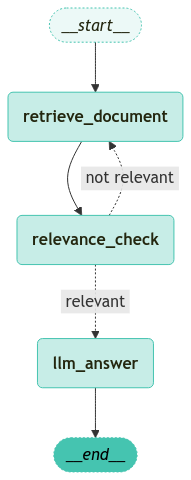

In [18]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from graphs import visualize_graph

# 그래프 정의 및 엣지 설정
workflow = StateGraph(GraphState)

# 노드 및 엣지 설정
workflow.add_node("retrieve_document", retrieve_document)
workflow.add_node("relevance_check", relevance_check)
workflow.add_node("llm_answer", llm_answer)

workflow.add_edge("retrieve_document", "relevance_check")

# 조건부 노드 추가
workflow.add_conditional_edges(
    "relevance_check",
    is_relevant,
    {"relevant": "llm_answer", "not relevant": "retrieve_document"},
)

workflow.add_edge("llm_answer", END)

# 시작 노드 설정
workflow.set_entry_point("retrieve_document")

# 메모리 설정
memory = MemorySaver()

# 그래프 생성
app = workflow.compile(checkpointer=memory)

# 그래프 시각화
visualize_graph(app)

In [20]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid

# 그래프 환경 설정
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 설정
inputs = GraphState(question="What is the purpose of the IS-183? in Korean")

# 그래프 실행
invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])

==== [Relevance Check] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('user', 'What is the purpose of the IS-183? in Korean')
('assistant', 'IS-183의 목적은 AI의 위험 유형을 식별하고 분석하여 안전한 AI 개발 및 활용을 촉진하는 것입니다. 이 보고서는 AI의 위험 요소를 분류하고, 각국의 AI 안전 전담기관과 기업들이 AI 위험에 대한 대응 방안을 수립하는 데 기여하고자 합니다.\n\n**Source**\n- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 8)')


In [21]:
# 그래프 토큰 스트리밍 출력
stream_graph(app, inputs, config, ["relevance_check", "llm_answer"])


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [Relevance Check] ====
yes

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
IS-183의 목적은 AI의 위험 요소를 식별하고 분석하여 안전한 AI 개발 및 활용을 촉진하는 것입니다. 이 보고서는 AI의 위험 요소를 분류하고, 각국의 AI 안전 전담기관과 기업들이 AI 위험에 대한 대응 방안을 수립하는 데 기여하고자 합니다.

**Source**
- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 8)

In [23]:
# get_state 는 그래프의 현재 상태를 가져옴
outputs = app.get_state(config).values

# 현재 상태의 질문을 출력
print(f'Question: {outputs["question"]}')
print("===" * 20)
# 현재 상태의 답변을 출력
print(f'Answer:\n{outputs["answer"]}')

Question: What is the purpose of the IS-183? in Korean
Answer:
IS-183의 목적은 AI의 위험 요소를 식별하고 분석하여 안전한 AI 개발 및 활용을 촉진하는 것입니다. 이 보고서는 AI의 위험 요소를 분류하고, 각국의 AI 안전 전담기관과 기업들이 AI 위험에 대한 대응 방안을 수립하는 데 기여하고자 합니다.

**Source**
- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 8)


In [25]:
# 현재 상태의 관련성 체크 결과를 출력
print(outputs["relevance"])

yes


현재 코드의 문제점 :  
- `relevance_check` 가 실패할 경우, 반복하여 동일한 Query 가 다시 `retrieve_document` 노드로 전달됩니다.
- 반복하여 동일한 Query 가 다시 `retrieve_document` 노드로 전달되면, 동일한 검색결과로 이어지기 때문에 결국 재귀상태에 빠지게 됩니다.
- 이러한 예외상황을 처리하기 위해, **재귀 최대 횟수(recursion_limit)** 를 설정합니다. 그리고 에러처리를 위해 `GraphRecursionError` 를 처리합니다.

In [26]:
from langchain_core.runnables import RunnableConfig
from langchain_print import stream_graph, invoke_graph, random_uuid
from langgraph.errors import GraphRecursionError

# 그래프 환경 설정
config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 설정
inputs = GraphState(question="What is the purpose of the IS-183? in Korean")

try:
    invoke_graph(app, inputs, config, ["relevance_check", "llm_answer"])
except GraphRecursionError as recursion_error:
    print(f"GraphRecursionError: {recursion_error}")

==== [Relevance Check] ====
yes

🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: llm_answer 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('user', 'What is the purpose of the IS-183? in Korean')
('assistant', 'IS-183의 목적은 AI의 위험 유형을 식별하고 분석하여 안전한 AI 개발 및 활용을 촉진하는 것입니다. 이 보고서는 AI의 위험 요소를 분류하고, 각국의 AI 안전 전담기관과 기업들이 AI 위험에 대한 대응 방안을 수립하는 데 기여합니다.\n\n**Source**\n- ./data/IS-183_AI 위험 유형 및 사례 분석(최종).pdf (페이지 8)')
